In [26]:
# Co-Register WV3 image to MSI data using 
# AROSICS https://danschef.git-pages.gfz-potsdam.de/arosics/doc/usage/global_coreg.html
# AND export after applying Sentinel 2 MSI point spread functions for equivalent bands
# 
# WV3 image extents are assumed to be in a feature collection on GEE named WV3asset 
# WV3 image is assumed to be on a local drive 
# YOU MUST HAVE YOUR GOOGLE DRIVE FOLDER Gdrive_cloud SYNCED TO LOCAL DRIVE Gdrive
# 

# inputs 

# select global or local coregistration
COREGTYPE = "local"

# specify WV3 product path and subproduct index 
WV3asset = "users/hemitshah/NEON/WV3CanadaCCRS" # Collection of WV3 tiles in GEE used to specify bounds of MSI data to subset
#WV3id = "wv3_20170612_N5310W06629" # The WV3 image ID, corresponds to "TITLEPrope" property of WV3 asset
#WV3path = "C:\\Users\\rfern\\downscaling\\010543783100_01\\" # Local path of WV3 product , we only use the MS data, it can have multiple images
#WV3datafolder = "010543783100_01_P002_MUL\\"  # Name of folder where the WV3 bands we will use lies 
#WV3product  = "17JUN12154136-M2AS-010543783100_01_P002"  # Name of The WV3 image within the product
WV3id = "wv3_20190618_N4976W11270" # lethbridge The WV3 image ID, corresponds to "TITLEPrope" property of WV3 asset
WV3path = "C:\\Users\\rfern\\downscaling\\012103460040_01\\" # Lethbridge Local path of WV3 product , we only use the MS data, it can have multiple images
WV3datafolder = "012103460040_01_P001_PAN\\"  # Lethbridge Name of folder where the WV3 bands we will use lies 
WV3product  = "19JUN18191029-P2AS-012103460040_01_P001"  # Lethbridge Name of The WV3 image within the product
#WV3id = "wv3_20170811_N5433W11722" # The WV3 image ID, corresponds to "TITLEPrope" property of WV3 asset
#WV3path = "C:\\Users\\rfern\\downscaling\\011834405010_01\\" # Local path of WV3 product , we only use the MS data, it can have multiple images
#WV3datafolder = "011834405010_01_P002_MUL\\"  # Name of folder where the WV3 bands we will use lies 
#WV3product  = "17JUN12154136-M2AS-010543783100_01_P002"  # Name of The WV3 image within the product

WV3band = 1 # the band we hope matches the MSIBand (1=red, 2=blue, 3=green, 4=NIR)
WV3filename = WV3path+WV3datafolder+WV3product  # constructed full file name except for suffix 

# specify the Sentinel 2 MSI Product in Google Earth Engine we will use as reference for co-registration
MSIasset = "COPERNICUS/S2/"  # L1C GEE collection
#MSIid = "20170612T153911_20170612T153906_T19UFU" # wabush Should have cloud free overlap with WV3 image. 0=no data
MSIid = "20190618T182929_20190618T184014_T12UUA" # lethbridge Should have cloud free overlap with WV3 image. 0=no data
#MSIid = "0170811T185921_20170811T190305_T11UMA # Fox Creek Should have cloud free overlap with WV3 image. 0=no data
MSIband = "B3" # the band we will use for coregistration
resample = 5 # resampling factor applied to MSI data prior to registration
Gdrive_cloud = "ExportedData" # The google drive on the cloud that is synced to local workstation
Gdrive = "C:\\Users\\rfern\\GoogleDriveHemit\\ExportedData" # The google drive on local workstation synced to Grdive_cloud
MSIfilename = Gdrive+"\\"+WV3id+"_"+MSIid # constructed full file name except for suffix 

# output (files automatically written to the location of the WV3 input data)

# WV3filename+"_"+COREGTYPE+".tif"  - spatially transformed version of WV3filename
# WV3filename+"_"+COREGTYPE+"_msi.tif"  - spatially transformed version of WV3filename with MSI PSF applied
# WV3filename+"_"+COREGTYPE+"_shadow.tif"  - raster with 0=terrain shadow 1=no terrain shadow for WV3 region
# WV3filename+"_"+COREGTYPE+".txt" - average global shifts 
# WV3filename+"_"+COREGTYPE+".csv" - specific local shifts (for COREGTYPE=local only)

In [27]:
%config IPCompleter.greedy=True

In [28]:
import cv2
import sys
import numpy as np
import fiona
import rasterio
import rasterio.mask
from rasterio import plot
from rasterio.enums import Resampling
from matplotlib import pyplot as p  
from geoarray import GeoArray
from arosics import COREG
from arosics import COREG_LOCAL
from arosics import DESHIFTER
from scipy.ndimage import gaussian_filter
from PIL import Image
import geopandas as gpd
import ee
import logging
import xml.etree.ElementTree as ET

In [4]:
# get access to GEE account that has WV3asset 
ee.Authenticate()

Enter verification code:  4/1AY0e-g7I0vs3QFCMym84Lnshf6hur1H1SE2Uo_feWpqROc8Q0Vc86IiZYrg



Successfully saved authorization token.


In [5]:
# start GEE
ee.Initialize()

In [6]:
# logging setup
logging.basicConfig(filename='WV3registration.log', level=logging.WARNING)

In [7]:
# save diagnostic output of registration and resampling functions to text file
stdout_fileno = sys.stdout
sys.stdout = open(WV3filename+"_"+COREGTYPE+".txt","w")

In [29]:
# in memory raster resampler function
# Example licensed under cc by-sa 3.0 with attribution required
from contextlib import contextmanager  
import rasterio
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling

# use context manager so DatasetReader and MemoryFile get cleaned up automatically
@contextmanager
def resample_raster(raster, scale=5):
    t = raster.transform

    # rescale the metadata
    transform = Affine(t.a / scale, t.b, t.c, t.d, t.e / scale, t.f)
    height = raster.height * scale
    width = raster.width * scale

    profile = src.profile
    profile.update(transform=transform, driver='GTiff', height=height, width=width)

    data = raster.read( # Note changed order of indexes, arrays are band, row, col order not row, col, band
            out_shape=(raster.count, height, width),
            resampling=Resampling.bilinear,
        )

    with MemoryFile() as memfile:
        with memfile.open(**profile) as dataset: # Open as DatasetWriter
            dataset.write(data)
            del data

        with memfile.open() as dataset:  # Reopen as DatasetReader
            yield dataset  # Note yield not return     


In [30]:
# to disk raster resampler function
# Example licensed under cc by-sa 3.0 with attribution required
from contextlib import contextmanager  
import rasterio
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling

# use context manager so DatasetReader and MemoryFile get cleaned up automatically
@contextmanager
def resample_rasterdisk(raster, filename,  scale=5):
    t = raster.transform

    # rescale the metadata
    transform = Affine(t.a / scale, t.b, t.c, t.d, t.e / scale, t.f)
    height = raster.height * scale
    width = raster.width * scale

    profile = src.profile
    profile.update(transform=transform, driver='GTiff', height=height, width=width)

    data = raster.read( # Note changed order of indexes, arrays are band, row, col order not row, col, band
            out_shape=(raster.count, height, width),
            resampling=Resampling.bilinear,
        )

    with rasterio.open(filename, 'w', **profile) as dataset: # Open as DatasetWriter
            dataset.write(data)
            del data
    return  

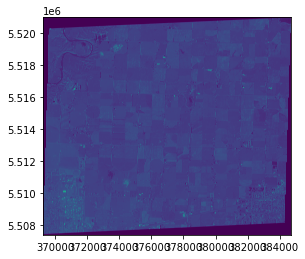

CRS.from_epsg(32612)

In [31]:
# check WV3 image on  local drive (optional)
WV3 = rasterio.open(WV3filename+".tif")
plot.show(WV3) 
WV3.crs

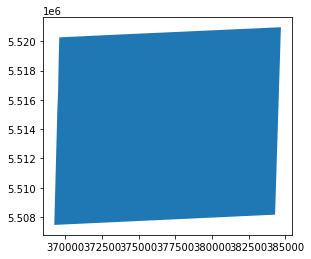

In [32]:
# get WV3 boundary polygon and add the projection info
WV3poly=gpd.read_file(WV3path + "GIS_FILES\\" + WV3product + "_PIXEL_SHAPE.shp")
WV3poly = WV3poly.to_crs(WV3.crs)
WV3poly.head()
WV3poly.plot()
WV3poly.crs
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [22]:
# export image with union of MSI and WV3 terrain shadows from GEE for masking using the MSI CRS
WV3meta =  ET.parse(WV3filename+".xml")
WV3geometry = (ee.Feature(ee.FeatureCollection(WV3asset).filterMetadata("TITLEPrope","equals",WV3id).first())).geometry()
vaaWV3 = float(WV3meta.find(".//MEANSATAZ").text)
vzaWV3 = 90 - float(WV3meta.find(".//MEANSATEL").text)
saaWV3 = float(WV3meta.find(".//MEANSUNAZ").text)
szaWV3 = 90 - float(WV3meta.find(".//MEANSUNEL").text)
imageMSI = ee.Image(MSIasset+MSIid)
vaaMSI = imageMSI.get("MEAN_INCIDENCE_AZIMUTH_ANGLE_B3").getInfo()
vzaMSI = imageMSI.get("MEAN_INCIDENCE_ZENITH_ANGLE_B3").getInfo()
saaMSI = imageMSI.get("MEAN_SOLAR_AZIMUTH_ANGLE").getInfo()
szaMSI = imageMSI.get("MEAN_SOLAR_ZENITH_ANGLE").getInfo()
dem = ee.Image("MERIT/DEM/v1_0_3").clip(WV3geometry).convolve(ee.Kernel.square(3));
task = ee.batch.Export.image.toDrive(
              image= ee.Terrain.hillShadow(dem, saaMSI, szaMSI).multiply(ee.Terrain.hillShadow(dem, vaaMSI, vzaMSI)).multiply(ee.Terrain.hillShadow(dem, saaWV3, szaWV3)).multiply(ee.Terrain.hillShadow(dem, vaaWV3, vzaWV3)),
              description= (WV3id+"_"+MSIid+"_DEM"),
              folder= Gdrive_cloud,
              fileNamePrefix= (WV3id+"_"+MSIid+"_DEM"),
              scale= 10,
              crs = ee.Image(MSIasset+MSIid).select("B3").projection().crs(),
              region= (ee.Feature(ee.FeatureCollection(WV3asset).filterMetadata("TITLEPrope","equals",WV3id).first())).geometry().getInfo()['coordinates']
            );
                
task.start()
taskstat = task.status()['state']
print(taskstat)
while taskstat == 'READY' or taskstat == 'RUNNING':
    taskstat = task.status()['state']
print(task.status())

KeyboardInterrupt: 

In [20]:
# check DEM image on  local drive (optional)
DEM = rasterio.open(MSIfilename+"_DEM.tif")
plot.show(DEM) 
DEM.crs

AttributeError: 'DatasetReader' object has no attribute 'to_crs'

In [12]:
# export selected MSI band subset overlapping requested WV3 asset feature to drive and hold until task is done
task = ee.batch.Export.image.toDrive(
              image= ee.Image(MSIasset+MSIid).select([MSIband]),
              description= (WV3id+"_"+MSIid),
              folder= Gdrive_cloud,
              fileNamePrefix= (WV3id+"_"+MSIid),
              scale= 10,
              region= (ee.Feature(ee.FeatureCollection(WV3asset).filterMetadata("TITLEPrope","equals",WV3id).first())).geometry().getInfo()['coordinates']
            );
                
task.start()


In [13]:
taskstat = task.status()['state']
print(taskstat)
while taskstat == 'READY' or taskstat == 'RUNNING':
    taskstat = task.status()['state']
print(task.status())

In [15]:
# subset and upsample the MSI image we will use for registration , the resampled image will be saved on the local google drive
with rasterio.open(MSIfilename+".tif",nodata=0) as MSI:
    MSI_img, MSI_transform = rasterio.mask.mask(MSI, getFeatures(WV3poly), crop=True)
    profile = MSI.profile    
    profile.update({"driver": "GTiff",
                     "height": MSI_img.shape[1],
                     "width": MSI_img.shape[2],
                     "transform": MSI_transform,
                     "crs": WV3.crs ,
                      "nodata":0 }
                       ) 
    with MemoryFile() as memfile:
        with memfile.open(**profile) as src: # Open as DatasetWriter
            src.write(MSI_img)
            del MSI_img          
            resample_rasterdisk(src,MSIfilename+"_"+str(resample)+".tif",resample) 

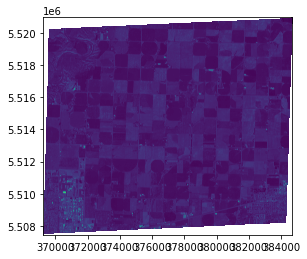

<AxesSubplot:>

In [33]:
# check MSIimage on  local drive (optional) - it may be bigger than the WV3 image as WV3 products have multiple images in footprint
MSItest = rasterio.open(MSIfilename+"_"+str(resample)+".tif",nodata=0)
plot.show(MSItest) 

In [24]:
# subset and upsample the DEM image 
with rasterio.open(MSIfilename+"_DEM.tif",nodata=0) as MSI:
    MSI_img, MSI_transform = rasterio.mask.mask(MSI, getFeatures(WV3poly), crop=True)
    profile = MSI.profile    
    profile.update({"driver": "GTiff",
                     "height": MSI_img.shape[1],
                     "width": MSI_img.shape[2],
                     "transform": MSI_transform,
                     "crs": WV3.crs ,
                      "nodata":0 }
                       ) 
    with MemoryFile() as memfile:
        with memfile.open(**profile) as src: # Open as DatasetWriter
            src.write(MSI_img)
            del MSI_img          
            resample_rasterdisk(src,WV3filename+COREGTYPE+"_shadow.tif",resample) 

RasterioIOError: C:/Users/rfern/GoogleDriveHemit/ExportedData/wv3_20190618_N4976W11270_20190618T182929_20190618T184014_T12UUA_DEM.tif: No such file or directory

In [ ]:
# register the WV3 image to the resampled MSI image using specified band 
geoArr  = GeoArray(MSIfilename+"_"+str(resample)+".tif")
ref_ndarray = geoArr[:]
ref_gt      = geoArr.geotransform
ref_prj     = geoArr.projection 
reference = GeoArray(ref_ndarray, ref_gt, ref_prj)

geoArr  = GeoArray( WV3filename+".tif") 
tar_ndarray = geoArr[:]
tar_gt      = geoArr.geotransform
tar_prj     = geoArr.projection 
target = GeoArray(tar_ndarray, tar_gt, tar_prj)
tar_wsize = 1024;

# registration
if COREGTYPE == "local":
    #local registration 
    CR = COREG_LOCAL(reference, target, grid_res = tar_wsize, window_size = (tar_wsize*2,tar_wsize*2), max_shift = tar_wsize*2, r_b4match= 1, s_b4match=WV3band,  nodata=(0,0),path_out=WV3filename+"_"+COREGTYPE+".tif",fmt_out="GTIFF")
    #CR.view_CoRegPoints(figsize=(15,15), backgroundIm='ref')
    CR.CoRegPoints_table
    CR.CoRegPoints_table.to_csv((WV3filename+"_"+COREGTYPE+".csv"))
else:
    try:
        CR = COREG(reference, target, ws = (tar_wsize,tar_wsize), max_shift = tar_wsize,  r_b4match= 1, s_b4match=WV3band,   nodata=(0,0),path_out=WV3filename+"_"+COREGTYPE+".tif",fmt_out="GTIFF")
    except LocalProcessing :
        COREGTYPE = "local"
        CR = COREG_LOCAL(reference, target, grid_res = tar_wsize, window_size = (tar_wsize*2,tar_wsize*2), max_shift = tar_wsize*2, r_b4match= 1, s_b4match=WV3band,  nodata=(0,0),path_out=WV3filename+"_"+COREGTYPE+".tif",fmt_out="GTIFF")
        #CR.view_CoRegPoints(figsize=(15,15), backgroundIm='ref')
        CR.CoRegPoints_table
        CR.CoRegPoints_table.to_csv((WV3filename+"_"+COREGTYPE+".csv"))
CR.calculate_spatial_shifts()




Note: array has been downsampled to 1000 x 877 for faster visualization.


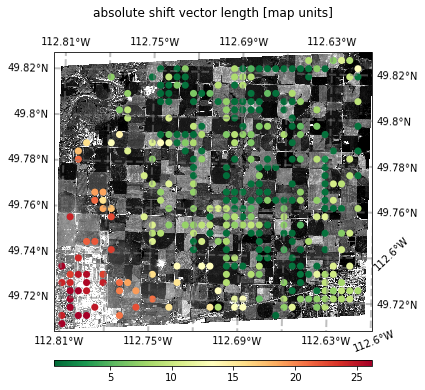

In [19]:
CR.CoRegPoints_table.to_csv((WV3filename+"_"+COREGTYPE+".csv"))
CR.view_CoRegPoints(savefigPath='012103460040_01',)


In [12]:
im2 = DESHIFTER(target, CR.coreg_info,path_out=WV3filename+"_"+COREGTYPE+".tif",fmt_out="GTIFF").correct_shifts()

Translating progress |===-----------------------------------------------| 6.8% Complete  => 0:00:00

Automatically detected nodata value for GeoArray 'IN_MEM': 0.0
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:02
Warping progress     |==================================================| 100.0% Complete  => 0:00:35


Writing GeoArray of size (6788, 7739, 8) to C:\Users\rfern\downscaling\012103460040_01\012103460040_01_P001_MUL\19JUN18191029-M2AS-012103460040_01_P001_local.tif.


In [13]:
# apply msi psf to wv3 VNIR image
# we assume the WV3 bands and corresponding MSI MTFs are as below
# WV3 band          MSI MTF stdev
# 1 = coastal       0.0173
# 2 = blue          0.0318
# 3 = green         0.0313
# 4 = yellow        0.0313
# 5 = red           0.0305
# 6 = red edge      0.0173
# 7 = nir1          0.0163
# 8 = nri2          0.0292
# The MSI MTFs are taken from Li et al. https://www.mdpi.com/2072-4292/12/15/2406/htm
sigmaf = np.array([0.0173,0.0318,0.0313,0.0313,0.0305,0.0173,0.0163,0.0292])
sigmal =  1/(sigmaf*2*3.14159256)
print(sigmal)
for x in range(1,8):
  im2['arr_shifted'][:,:,x] =  gaussian_filter( np.array(im2['arr_shifted'][:,:,x],dtype=np.uint16),sigma=sigmal[x])
im2['GeoArray_shifted'].save(out_path=WV3filename+"_"+COREGTYPE+"_MSI.tif",fmt="GTIFF")

[9.19970797 5.00487257 5.08482261 5.08482261 5.21819501 9.19970797
 9.76410723 5.45051191]
Writing GeoArray of size (6788, 7739, 8) to C:\Users\rfern\downscaling\012103460040_01\012103460040_01_P001_MUL\19JUN18191029-M2AS-012103460040_01_P001_local_MSI.tif.


In [14]:
# apply coarsest msi psf to wv3 VNIR image
# we assume the WV3 bands and corresponding MSI MTFs are as below
# WV3 band          MSI MTF stdev
# 1 = coastal       0.0173
# 2 = blue          0.0318
# 3 = green         0.0313
# 4 = yellow        0.0313
# 5 = red           0.0305
# 6 = red edge      0.0173
# 7 = nir1          0.0163
# 8 = nri2          0.0292
# The MSI MTFs are taken from Li et al. https://www.mdpi.com/2072-4292/12/15/2406/htm
sigmaf = np.array([0.0173,0.0173,0.0173,0.0173,0.0173,0.0173,0.0173,0.0173])
sigmal =  1/(sigmaf*2*3.14159256)
print(sigmal)
for x in range(1,8):
  im2['arr_shifted'][:,:,x] =  gaussian_filter( np.array(im2['arr_shifted'][:,:,x],dtype=np.uint16),sigma=sigmal[x])
im2['GeoArray_shifted'].save(out_path=WV3filename+"_"+COREGTYPE+"_MSI20MPSF.tif",fmt="GTIFF")

[9.19970797 9.19970797 9.19970797 9.19970797 9.19970797 9.19970797
 9.19970797 9.19970797]
Writing GeoArray of size (6788, 7739, 8) to C:\Users\rfern\downscaling\012103460040_01\012103460040_01_P001_MUL\19JUN18191029-M2AS-012103460040_01_P001_local_MSI20MPSF.tif.


In [12]:
# Close the diagnostic text file
sys.stdout.close()
# Restore sys.stdout to our old saved file handler
sys.stdout = stdout_fileno

NameError: name 'stdout_fileno' is not defined